# Load Library

In [6]:
import torch
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Load Data and Get Insight

In [7]:
root_folder = '../input/minerals-identification-dataset/minet'
target_label = ['biotite', 'bornite', 'chrysocolla', 'malachite', 
                'muscovite', 'pyrite', 'quartz']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#load data and tranform it into tensor
dataset = ImageFolder(root_folder, transform=transforms.ToTensor())
print('Data size: ',len(dataset))
dataset.classes

Data size:  956


['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

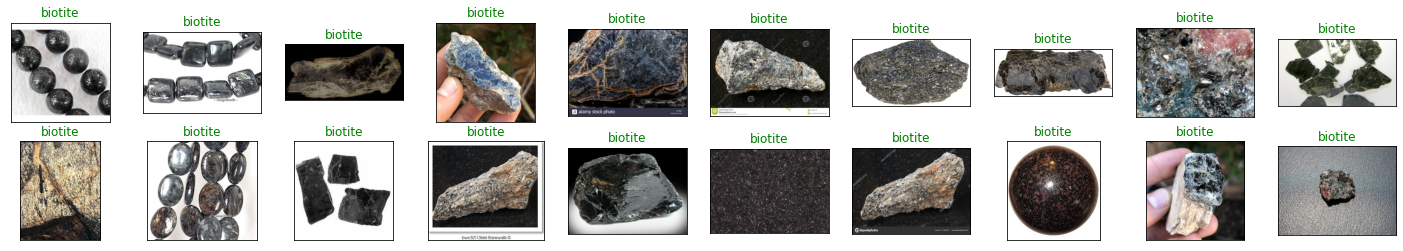

In [9]:
#check images of the dataset for first 20 images
fig = plt.figure(figsize=(25, 4))

for i in range(20):
    image, label = dataset[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

In [10]:
#count number for each label
count = {}

for i in range(len(dataset)):
    _, labels = dataset[i]
    label = target_label[labels]
    if label not in count:
        count[label] = 1
    elif label in count:
        count[label] += 1

#insert count into dataframe
df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Mineral', 'count']
df

,Mineral,count
0,biotite,68
1,bornite,170
2,chrysocolla,163
3,malachite,235
4,muscovite,77
5,pyrite,98
6,quartz,145


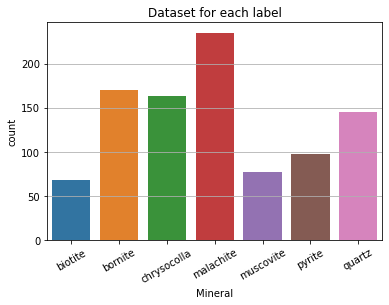

In [11]:
#plot barplot for the sake of easy to read
sns.barplot(df['Mineral'], df['count'])
plt.title('Dataset for each label');
plt.xticks(rotation=30)
plt.grid(axis='y')

In [12]:
#check image size for all datasets
# torch.FloatTensor of shape (C x H x W) 
height = []
weight = []
for i in range(len(dataset)):
    image, label = dataset[i]
    height.append(image.size(1))
    weight.append(image.size(2))
print(f"maximum_height:{np.max(height)} \tminimum_height:{np.min(height)} \tmean_height:{np.mean(height)}")
print(f"maximum_weight:{np.max(weight)} \tminimum_weight:{np.min(weight)} \tmean_weight:{np.mean(weight)}")

maximum_height:6016 	minimum_height:129 	mean_height:696.7426778242677
maximum_weight:6016 	minimum_weight:144 	mean_weight:806.3995815899582


# Data Loader

## Load All Data

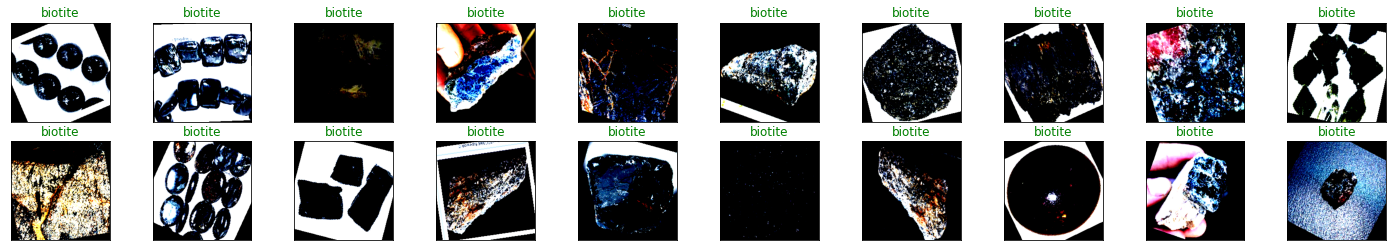

In [13]:
#transform format to augmetation dataset beacuse our dataset only has 956 images
#I reload the data and do multiple transformation and resize it
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.RandomRotation(30), 
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])]) #imagenet mean and std

load_data = ImageFolder(root_folder, transform=data_transform)

#check the images result from transformation
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    image, label = load_data[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

## Split Data

In [14]:
# split base on random_split

# #ration for data split
# train_ratio = 0.90 
# train_size = int(len(load_data)*train_ratio) #90% data training
# val_size = int((len(load_data) - train_size) * 0.5)  #5% validation
# test_size = len(load_data) - (train_size + val_size) #5% testing

# datasize = len(load_data)
# data_idx = [x for x in range(datasize)]

# np.random.seed(97)
# np.random.shuffle(data_idx)

# train_idx = data_idx[:train_size]
# val_idx = data_idx[train_size:-test_size]
# test_idx = data_idx[train_size+val_size:]
# # #split data into 3 parts train, validation and testing
# # #train_set, val_set, test_set = random_split(load_data, [train_size, val_size, test_size])
# print('size of training data: ', len(train_idx))
# print('size of validation data: ', len(val_idx))
# print('size of test data: ', len(test_idx))

In [15]:
def plot_dist(indexes, dataset=dataset):
    #dist = {}
    count = Counter()
    for i in indexes:
        _, label = dataset[i]
        count[target_label[label]] += 1
    
    # for i in indexes:
    #     img, labels = dataset[i]
    #     label = target_label[labels]
    #     if label not in dist:
    #         dist[label] = 1
    #     elif label in dist:
    #         dist[label] +=1

    dist_2 = dict(sorted(count.items(), key=lambda kv: kv[1], reverse=True))
    plt.bar(dist_2.keys(), dist_2.values())
    plt.xticks(rotation=30)
    plt.title('Data distribution'); plt.ylabel('count')
    plt.show()

In [16]:
# split data to get the same distributiom


#get index and its label
idx_label = {}
for i in range(len(dataset)):
    _, label = dataset[i]
    idx_label[i] = label

#split for data validation
x_train, x_val, y_train, y_val = train_test_split(list(idx_label.keys()), list(idx_label.values()), 
                                                  stratify = list(idx_label.values()), test_size=0.05)



In [17]:
#exclude validation index from dataset
x_val
idx_label_2 = {}
for idx, label in idx_label.items():
    if idx not in x_val:
        idx_label_2[idx] = label

#split data train and test after exlude x_val
x_train, x_test, y_train, y_test = train_test_split(list(idx_label_2.keys()), list(idx_label_2.values()),
                                                    stratify = list(idx_label_2.values()), test_size=0.05)
print(len(x_train))
print(len(x_val))
print(len(x_test))

862
48
46


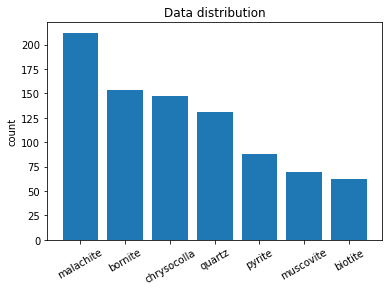

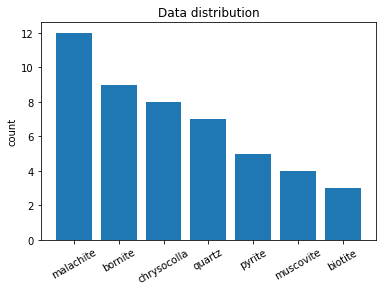

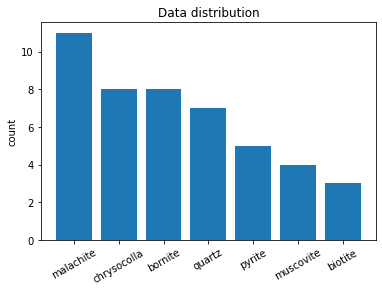

In [18]:
plot_dist(x_train)
plot_dist(x_val)
plot_dist(x_test)

In [19]:
#load into dataloader for each data after split it
batch_size = 128

#using subset to get data from indexes with the same distribution label
train_set = SubsetRandomSampler(x_train)
val_set = SubsetRandomSampler(x_val)
test_set = SubsetRandomSampler(x_test)

#dataloader
train_loader = DataLoader(load_data, batch_size=batch_size, 
                          shuffle=False, num_workers=4, sampler= train_set)
val_loader = DataLoader(load_data, batch_size=batch_size,  
                        num_workers=4, sampler=val_set)
test_loader = DataLoader(load_data, batch_size=batch_size,
                         num_workers=4, sampler=test_set)

images.shape: torch.Size([128, 3, 224, 224])


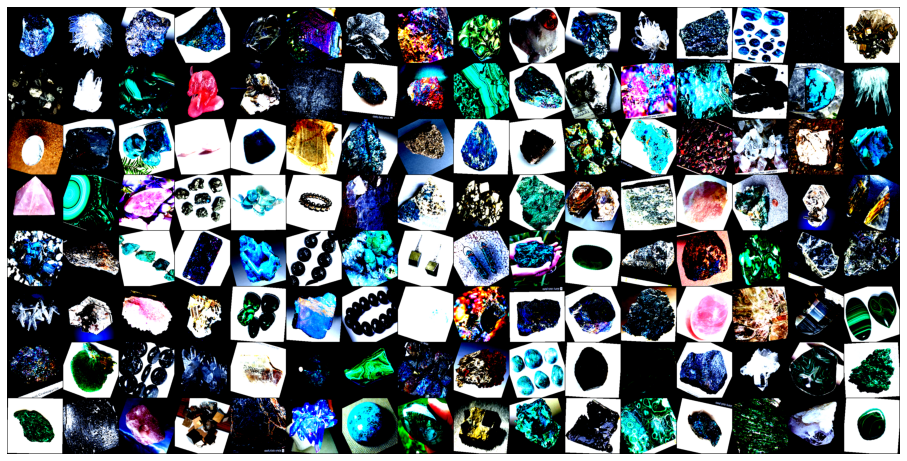

In [20]:
#check image in trainloader for one batch
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Build Model

In [21]:
#calculation for convnet
w1 = 20
F_SIZE= 3
F_POOL = 3
P = 0
S_SIZE = 1
S_POOL = 3

SIZE = (w1 - F_SIZE + 2*P)/S_SIZE+1 #size after conv
POOL = (SIZE - F_POOL)/S_POOL+1
w1 = POOL #size after pool
print(SIZE)
w1

18.0


6.0

In [22]:
6*6*64

2304

## My own model

In [23]:
class Mineral_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 48, 11, stride=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), #out 70x70

            nn.Conv2d(48, 128, 5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1),#out 64x64

            nn.Conv2d(128, 128, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(4, 3),#out 20x20

            nn.Conv2d(128, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),#out 20x20

            nn.Flatten(),
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 7),
            nn.LogSoftmax(dim=1),
            )
        
    def forward(self, x):
        out = self.net(x)
        return out

model_1 = Mineral_1()
model_1.to(device)
model_1

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax()
  )
)

In [24]:
# # model paper
# class Mineral(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # input shape  (3, 224x224) W2=(W1−F+2P)/S+1
#         self.conv1 = nn.Conv2d(3, 48, 7, stride=3, padding=1)
#         self.conv2 = nn.Conv2d(48, 128, 5, stride=3, padding=1)
#         self.conv3 = nn.Conv2d(128, 128, 4, stride=2, padding=1)
#         self.conv4 = nn.Conv2d(128, 128, 4, stride=1, padding=1)
        
#         self.pool = nn.MaxPool2d(3,1) #(W1−F)/S+1
 
#         #Classifier layer
#         self.fc1 = nn.Linear(4608, 512)
#         self.fc2 = nn.Linear(512,7)
        
#         #dropout for minimalize overfitting
#         self.drop = nn.Dropout(p=0.3)
#         self.soft = nn.LogSoftmax(dim=1)
    
#     def forward(self, x):
#         #conv layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))  
 
#         #Dense Layers
#         #flattening the input from conv layers
#         x = x.view(x.size(0), -1)
#         # add dropout layer
#         x = self.drop(F.relu(self.fc1(x)))
#         x = self.soft(self.fc2(x))
        
#         return x

# model = Mineral()

# criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# model.to(device);
# model

In [25]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    train_accu = []
    val_accu = []
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_acc = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            image = image.to(device); label = label.to(device);

            output = model(image)
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_acc += torch.mean(correct.type(torch.FloatTensor))

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for image, label in val_loader:
                    image = image.to(device); label = label.to(device);

                    output = model(image)
                    loss = criterion(output, label)

                    ps = torch.exp(output)
                    _, top_class = ps.topk(1, dim=1)
                    correct = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(correct.type(torch.FloatTensor))

                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            train_accu.append(train_acc/len(train_loader))
            val_accu.append(accuracy/len(val_loader))
            model.train()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Train Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
                  "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                  "Test Accuracy: {:.3f}.. ".format(accuracy/len(val_loader)),
                  "Time: {:.2f}s" .format((time.time()-since)))
    
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 
               'train_accuracy': train_accu, 'val_accuracy':val_accu}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [26]:
#saving model
def save_model(model, optim, fpath):
    checkpoint = {'model' : model,
                'state_dict': model.state_dict(),
                'optim' : optim.state_dict()
                }

    torch.save(checkpoint, fpath)

#load model
def load_model(fpath, inferece = True):
    check = torch.load(fpath)
    model = check['model']
    model.load_state_dict(check['state_dict'])
    if inferece:
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
    else:
        model.train()
    return model

In [27]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
epoch = 40
history_mineral = fit(epoch, model_1, train_loader, val_loader, criterion, optimizer)

Epoch: 1/40..  Train Loss: 1.903..  Test Loss: 1.813..  Train Accuracy: 0.242..  Test Accuracy: 0.250..  Time: 38.11s
Epoch: 2/40..  Train Loss: 1.781..  Test Loss: 1.670..  Train Accuracy: 0.297..  Test Accuracy: 0.396..  Time: 38.29s
Epoch: 3/40..  Train Loss: 1.599..  Test Loss: 1.440..  Train Accuracy: 0.392..  Test Accuracy: 0.396..  Time: 37.44s
Epoch: 4/40..  Train Loss: 1.352..  Test Loss: 1.147..  Train Accuracy: 0.465..  Test Accuracy: 0.521..  Time: 37.78s
Epoch: 5/40..  Train Loss: 1.266..  Test Loss: 1.092..  Train Accuracy: 0.500..  Test Accuracy: 0.542..  Time: 37.55s
Epoch: 6/40..  Train Loss: 1.137..  Test Loss: 1.030..  Train Accuracy: 0.573..  Test Accuracy: 0.562..  Time: 38.69s
Epoch: 7/40..  Train Loss: 1.027..  Test Loss: 0.914..  Train Accuracy: 0.624..  Test Accuracy: 0.646..  Time: 42.40s
Epoch: 8/40..  Train Loss: 0.973..  Test Loss: 0.809..  Train Accuracy: 0.634..  Test Accuracy: 0.688..  Time: 38.87s
Epoch: 9/40..  Train Loss: 0.963..  Test Loss: 0.713..  

In [28]:
#save mode
save_model(model_1, optimizer, 'mineral_seq_own.pt')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Mineral_1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


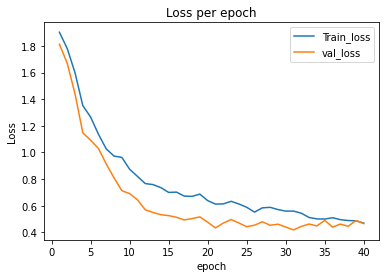

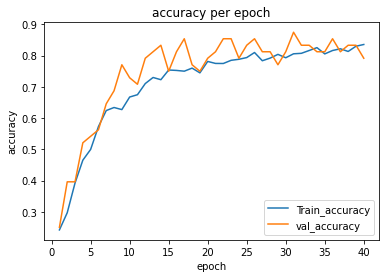

In [29]:
def plot_loss(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_loss'], label='Train_loss')
    plt.plot(epoch, history['val_loss'], label='val_loss')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()

def plot_accuracy(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_accuracy'], label='Train_accuracy')
    plt.plot(epoch, history['val_accuracy'], label='val_accuracy')
    plt.title('accuracy per epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()
plot_loss(history_mineral, epoch)
plot_accuracy(history_mineral, epoch)

## Pre-trained mode

In [30]:
from torchvision import models

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelVGG = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in modelVGG.parameters():
    param.requires_grad = False

#vgg16
modelVGG.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.5),
                                 nn.Linear(in_features=4096, out_features=1000),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.5),
                                 nn.Linear(in_features=1000, out_features=500),
                                 nn.Linear(500, 7),
                                 nn.LogSoftmax(dim=1))

#vgg19
# model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
#                                  nn.ReLU(inplace=True),
#                                  nn.Dropout(p=0.5, inplace=False),
#                                  nn.Linear(in_features=4096, out_features=4096, bias=True),
#                                  nn.ReLU(inplace=True),
#                                  nn.Dropout(p=0.5, inplace=False),
#                                  nn.Linear(in_features=4096, out_features=7, bias=True),
#                                  nn.LogSoftmax(dim=1))



modelVGG.to(device);
modelVGG.train()
modelVGG

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(modelVGG.classifier.parameters(), lr=0.0001)
epoch = 40
history_VGG = fit(epoch, modelVGG, train_loader, val_loader, criterion, optimizer)

Epoch: 1/40..  Train Loss: 1.752..  Test Loss: 1.404..  Train Accuracy: 0.321..  Test Accuracy: 0.625..  Time: 40.74s
Epoch: 2/40..  Train Loss: 1.267..  Test Loss: 0.904..  Train Accuracy: 0.570..  Test Accuracy: 0.708..  Time: 38.13s
Epoch: 3/40..  Train Loss: 0.915..  Test Loss: 0.700..  Train Accuracy: 0.664..  Test Accuracy: 0.729..  Time: 39.03s
Epoch: 4/40..  Train Loss: 0.713..  Test Loss: 0.537..  Train Accuracy: 0.742..  Test Accuracy: 0.833..  Time: 38.56s
Epoch: 5/40..  Train Loss: 0.546..  Test Loss: 0.390..  Train Accuracy: 0.806..  Test Accuracy: 0.833..  Time: 38.24s
Epoch: 6/40..  Train Loss: 0.460..  Test Loss: 0.412..  Train Accuracy: 0.846..  Test Accuracy: 0.833..  Time: 39.04s
Epoch: 7/40..  Train Loss: 0.446..  Test Loss: 0.421..  Train Accuracy: 0.849..  Test Accuracy: 0.812..  Time: 38.53s
Epoch: 8/40..  Train Loss: 0.393..  Test Loss: 0.477..  Train Accuracy: 0.854..  Test Accuracy: 0.771..  Time: 38.02s
Epoch: 9/40..  Train Loss: 0.371..  Test Loss: 0.365..  

In [32]:
save_model(modelVGG,  optimizer, 'mineral_vgg.pt')

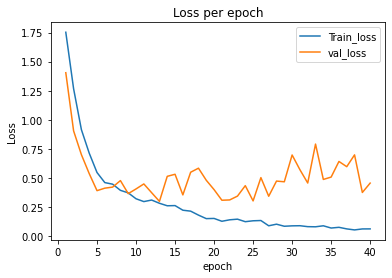

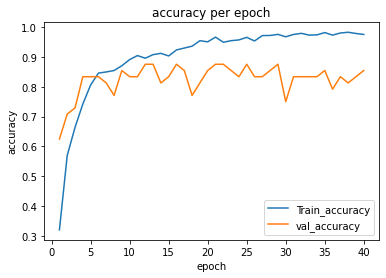

In [33]:
plot_loss(history_VGG, epoch)
plot_accuracy(history_VGG, epoch)

# Prediction and Evaluation

In [40]:
def predict_label(model, dataloader):
    prediction_list = []
    labels = []
    model.to(device)
    model.eval()
    for i, batch in enumerate(dataloader):
        image, label = batch
        image = image.to(device); label = label.to(device)
      
        out = model(image)
        ps = torch.exp(out)
        _, top_class = torch.max(ps , 1)
        preds = np.squeeze(top_class.cpu().numpy())
        prediction_list.append(preds)
        labels.append(label.cpu().numpy())
    return np.squeeze(prediction_list), np.squeeze(labels)

In [35]:
def predict_plot(test_loader, model, target_label=target_label, n=20):

    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        images = images.cuda()

    model.eval()
    # get sample outputs
    model.to(device)
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy()) #np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    images = images.cpu()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(n):
        ax = fig.add_subplot(2, n/2, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx].permute(1 ,2, 0))
        ax.set_title("{} ({})".format(target_label[preds[idx]], target_label[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.show()

## My Model 

In [37]:
model_mineral = load_model('mineral_seq_own.pt', inferece=True)
model_mineral

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax()
  )
)

In [64]:
#how model perfome in test_data
y_predict, y_true = predict_label(model_mineral, test_loader)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.55      0.75      0.63         8
           2       0.78      0.88      0.82         8
           3       0.90      0.82      0.86        11
           4       0.33      0.25      0.29         4
           5       0.67      0.80      0.73         5
           6       1.00      0.57      0.73         7

    accuracy                           0.72        46
   macro avg       0.70      0.68      0.67        46
weighted avg       0.74      0.72      0.72        46



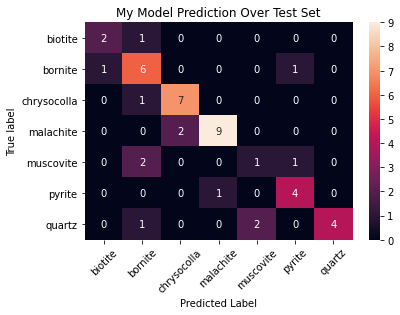

In [65]:
#plot confusion matric
print(classification_report(y_true, y_predict))
sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
plt.ylabel('True label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=0);
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=45)
plt.title('My Model Prediction Over Test Set')
plt.show()

I still don't know why my model only learn one class but it's not for pre-trained model so the dataloader not the problem

## VGG Model

In [66]:
model_vgg = load_model('mineral_vgg.pt', inferece=True)

In [71]:
#how model perfome in test_data
y_predict_vgg, y_true_vgg = predict_label(model_vgg, test_loader)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.64      0.88      0.74         8
           2       0.86      0.75      0.80         8
           3       1.00      0.73      0.84        11
           4       1.00      0.50      0.67         4
           5       0.62      1.00      0.77         5
           6       0.62      0.71      0.67         7

    accuracy                           0.76        46
   macro avg       0.82      0.75      0.75        46
weighted avg       0.81      0.76      0.76        46



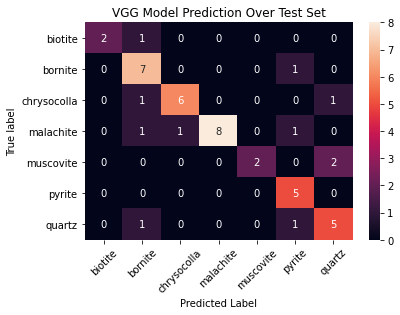

In [73]:
#plot confusion matric
print(classification_report(y_true_vgg, y_predict_vgg))
sns.heatmap(confusion_matrix(y_true_vgg, y_predict_vgg), annot=True)
plt.ylabel('True label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=0);
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=45)
plt.title('VGG Model Prediction Over Test Set')
plt.show()

## Plot Prediction

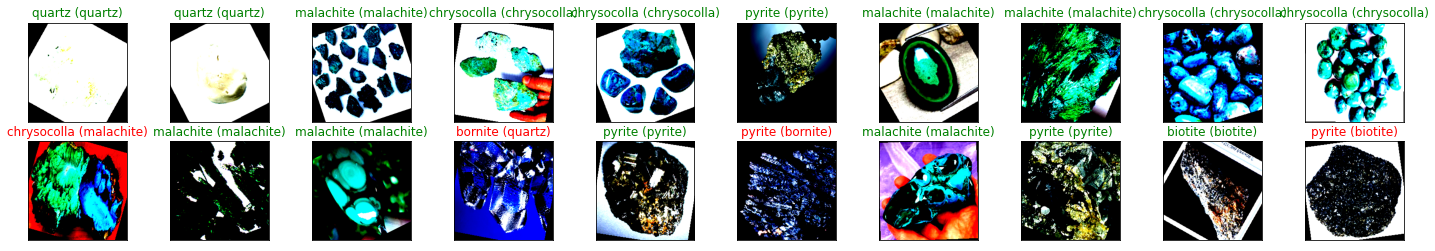

In [69]:
predict_plot(test_loader, model_vgg)

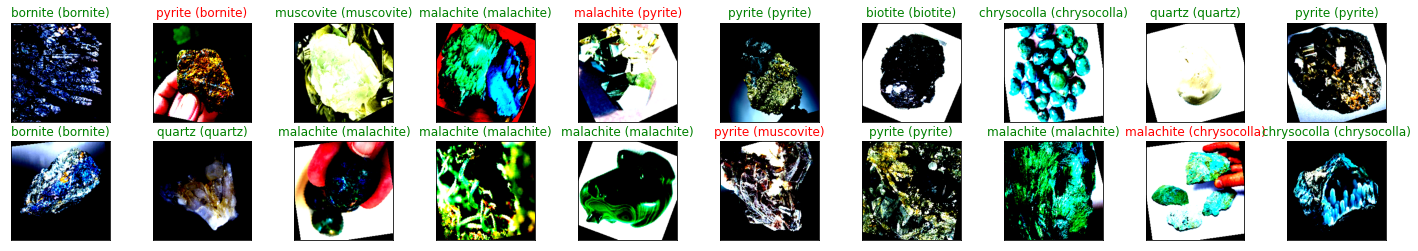

In [70]:
predict_plot(test_loader, model_mineral)